# Airbnb Growth Case Study: Performance Marketing Analysis

##Intro

Airbnb is a two-sided marketplace which matches guests to hosts. The Growth Marketing team runs guest acquisition campaigns across a variety of paid channels including Google Adwords and Facebook Ads. This team’s operational goal is to maximize booking revenue within a given budget. This is a sample analysis of the paid acquisition campaigns run from June - August 2018. The paid marketing campaign used is fabricated.

##Prompt

1. How much money did Airbnb spend on the paid marketing in August and how many bookings did they drive?

2. What other key metrics would you propose to measure the overall success of this program? Make sure to clearly define these metric(s) and explain how each is computed.

3. What areas of the program are doing well and what could be improved? This includes (but is not limited to) advertising platforms, languages, origin/destination markets, campaign types, etc.

4. The team has an additional $1m to invest next month. Which areas should we invest in to get the best return?

5.  There is also interest from executives at Airbnb about the work the team is doing, and a desire to understand the broader framing of paid user acquisition, thinking beyond the data provided. What other research, experiments, or approaches could help the team and the company get more clarity on the problem?



In [11]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# set jupyter's max row display
pd.set_option('display.max_row', 1000)
# set jupyter's max column width to 50
pd.set_option('display.max_columns', 50)

#import dataset
costs = pd.read_csv('costs.csv').sort_values(by=['calendar_date','tracking_key'])
bookings = pd.read_csv('bookings.csv').sort_values(by=['calendar_date','tracking_key'])
revenue = pd.read_csv('revenue.csv').sort_values(by=['calendar_date','tracking_key'])



## The Data

`costs` (105k rows):
* `calendar_date`: Date of the event
* `tracking_key`: Unique tracking key of the event
* `dim_origin_country`: Origin country of the user
* `dim_origin_region`: Origin region of the user
* `platform`: Advertising platform name
* `match_type`: Keyword match type, if applicable
* `language`: User’s language 
* `destination_country`: User’s destination country 
* `campaign_strategy`: Campaign strategy 
* `is_remarketing`: Binary flag to identify remarketing campaigns 
* `channel`: Type of the acquisition channel 
* `impressions`: Number of impressions 
* `clicks`: Number of clicks 
* `cost`: Cost in USD


`bookings` (101k rows):
* `calendar_date`: Date of the event
* `tracking_key`: Unique tracking key of the event
* `bookings`: Number of bookings

`revenue` (101k rows):
* `calendar_date`: Date of the event
* `tracking_key`: Unique tracking key of the event
* `revenue`: Booking revenue in USD

In [12]:
#convert calendar dates to datetimes
costs['calendar_date'] = pd.to_datetime(costs['calendar_date'], format='%Y-%m-%d')
bookings['calendar_date'] = pd.to_datetime(bookings['calendar_date'], format='%Y-%m-%d')
revenue['calendar_date'] = pd.to_datetime(revenue['calendar_date'], format='%Y-%m-%d')

#convert categories to categorical variable types 
categoricals = costs.columns[2:11].tolist()

def category(column):
    costs[column] = costs[column].astype('category')
    
for i in categoricals:
    category(i)
    

#join bookings and revenue tables 
br = pd.merge(bookings, revenue, how='left')

#joining costs - full data set 
df = pd.merge(costs,br,how='inner')

### 1. Finding total spend and total bookings for August

In [13]:
#split df into dupes and no dupes
df_dupes = df[df.duplicated(['calendar_date','tracking_key', 'bookings', 'revenue'],keep=False) == True]

#aggregate dupes
df_dupes = df_dupes.groupby(['calendar_date','tracking_key'],as_index=False).agg({'impressions':sum,
                           'clicks':sum,
                           'cost':sum, 
                           'bookings':np.mean,
                           'revenue':np.mean,})


df_no_dupes = df[df.duplicated(['calendar_date','tracking_key', 'bookings', 'revenue'],keep=False) == False]
df_no_dupes = df_no_dupes.groupby(['calendar_date' ,'tracking_key'],as_index=False).sum()

#Rejoin df_dupes and df_no_dupes into data
data = pd.concat([df_no_dupes,df_dupes], ignore_index=True)

#group data by week, month
weekly_data = data.groupby([pd.Grouper(key='calendar_date',freq='W')]).agg(sum)
monthly_data = data.groupby([pd.Grouper(key='calendar_date',freq='MS')]).agg(sum)

print('Total Spend in August = ${0:.0f}'.format(monthly_data.loc['2018-08-01','cost']))
print('Total Bookings in August = {0:.0f}'.format(monthly_data.loc['2018-08-01','bookings']))
monthly_data.head()

Total Spend in August = $61961618
Total Bookings in August = 1096833


,impressions,clicks,cost,bookings,revenue
calendar_date,,,,,
2018-06-01,2.110060e+09,126580997.0,7.807379e+07,1154970.0,72220970.64
2018-07-01,2.409700e+09,154628678.0,9.169951e+07,1301586.0,81082307.67
2018-08-01,2.149086e+09,126536024.0,6.196162e+07,1096833.0,67757901.12


### 2. Calculating Paid Marketing Metrics

In [14]:
#create function to calculate marketing metrics for a df
def get_stats(df):
    #advertising metrics
    df.loc[:,'cpm'] = df.loc[:,'cost'] * 1000 / df.loc[:,'impressions']

    df.loc[:,'cpc'] = df.loc[:,'cost'] / df.loc[:,'clicks']
    
    df.loc[:,'cost_per_acq'] = df.loc[:,'cost'] / df.loc[:,'bookings']
    
    df.loc[:,'roas'] = (df.loc[:,'revenue'] - df.loc[:,'cost'])/ df.loc[:,'cost']
    
    #replacing infinite values with NaN
    df['cpc'] = df['cpc'].replace(np.inf, np.nan)
    df['cost_per_acq'] = df['cost_per_acq'].replace(np.inf, np.nan)

sample_data = data.sort_values(by='bookings',ascending=False)
get_stats(sample_data)
sample_data.head()

,calendar_date,tracking_key,impressions,clicks,cost,bookings,revenue,cpm,cpc,cost_per_acq,roas
89034,2018-07-10,F694E4682B3E8394,848694.0,473150.0,130703.81,5898.0,400065.12,154.005814,0.276242,22.160700,2.060853
89438,2018-07-17,F694E4682B3E8394,826206.0,457732.0,118635.13,5841.0,421255.38,143.590255,0.259180,20.310757,2.550849
89144,2018-07-12,F694E4682B3E8394,779002.0,433414.0,115208.59,5742.0,411970.65,147.892547,0.265816,20.064192,2.575867
88300,2018-06-27,F694E4682B3E8394,804986.0,452173.0,147823.12,5589.0,396592.56,183.634399,0.326917,26.448939,1.682886
87385,2018-06-12,F694E4682B3E8394,790865.0,433134.0,118337.50,5571.0,392568.54,149.630468,0.273212,21.241698,2.317364


### 3. What areas of the program are doing well? 

####Let's start by looking at campaigns grouped by platform/channel 

In [15]:

#GROUP BY PLATFORM/CHANNEL 

#split data
pc_no_dupes = df[df.duplicated(['calendar_date','tracking_key','platform','channel', 'bookings', 'revenue'],keep=False) == False]
pc_no_dupes = pc_no_dupes.groupby(['calendar_date','tracking_key', 'platform','channel'],as_index=False).agg({'impressions':sum,'clicks':sum,'cost':sum, 'bookings':sum,'revenue':sum})

#de-dupe
pc_dupes = df[df.duplicated(['calendar_date','tracking_key','platform','channel', 'bookings', 'revenue'],keep=False) == True]
pc_dupes = pc_dupes.groupby(['calendar_date','tracking_key', 'platform','channel'],as_index=False).agg({'impressions':sum,'clicks':sum,'cost':sum, 'bookings':np.mean,'revenue':np.mean})

#Platform/Channel Daily Data 
pc = pd.concat([pc_no_dupes,pc_dupes], ignore_index=True)

#aggregate platform/channel data by totals,weekly, and month
pc_data = pc.groupby(['channel','platform']).agg(sum).sort_values(by='bookings', ascending=False).dropna(axis=0,how='any')


############## OVERALL CONVERSION STATS FOR TOP 3 CHANNELS — Table 1 #######################

def cpa(df):
    #df.loc[:,'cpc'] = df.loc[:,'cost'] / df.loc[:,'clicks']
    #df.loc[:,'conv. rate'] = df.loc[:,'bookings'] / df.loc[:,'clicks']
    df.loc[:,'cost_per_acq'] = df.loc[:,'cost'] / df.loc[:,'bookings']
    df.loc[:,'roas'] = (df.loc[:,'revenue'] - df.loc[:,'cost'])/ df.loc[:,'cost']
    
    
############## OVERALL CONVERSION STATS  — Table 1 #######################


pc_data.index = pc_data.index.map('/'.join).str.strip('/')

pc_data_cb = pc_data[['cost','bookings','revenue']]

pc_data_cb.loc[:,'% of costs'] = pc_data.loc[:,'cost'] / pc_data.loc[:,'cost'].sum()
pc_data_cb.loc[:,'% of bookings'] = pc_data.loc[:,'bookings'] / pc_data.loc[:,'bookings'].sum()
pc_data_cb.loc[:,'% of revenue'] = pc_data.loc[:,'revenue'] / pc_data.loc[:,'revenue'].sum()

pc_data_cb = pc_data_cb[['cost','% of costs','bookings','% of bookings','revenue','% of revenue']]



table1 = pc_data_cb.head(3)


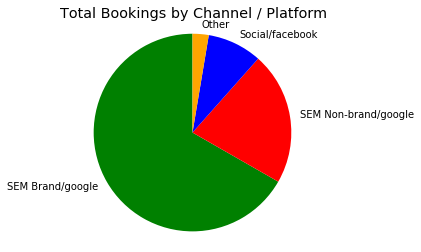

In [16]:
labels = 'SEM Brand/google', 'SEM Non-brand/google', 'Social/facebook', 'Other'
sections = [2358096, 767511, 315366, 93291]
colors = ['g', 'r', 'b', 'orange']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90)
plt.axis('equal') # Try commenting this out.
plt.title('Total Bookings by Channel / Platform')
plt.show()



Text(0, 0.5, 'return on ad spend')

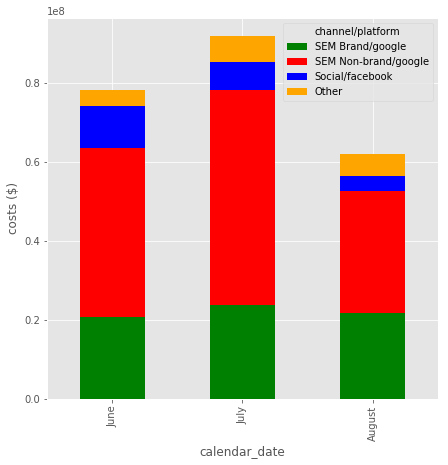

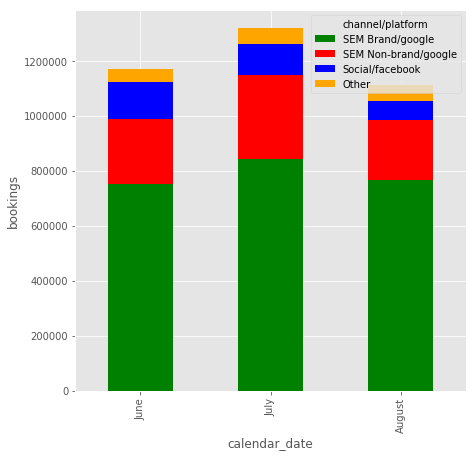

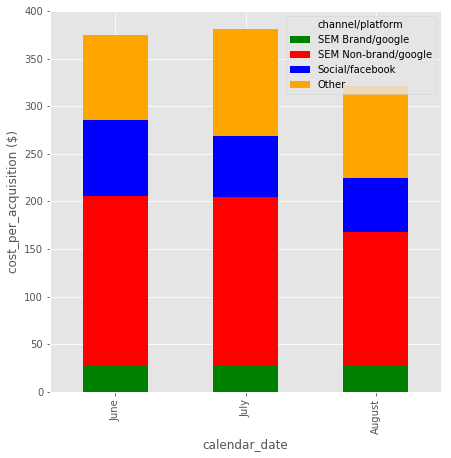

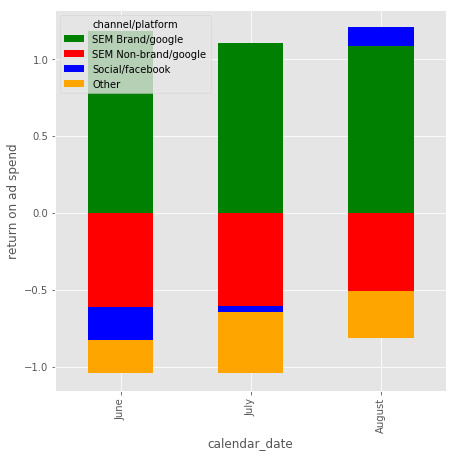

In [17]:

pc_by_month = pc.groupby([pd.Grouper(key='calendar_date',freq='MS'), 'channel', 'platform']).sum().dropna(axis=0,how='any').reset_index()
pc_by_week = pc.groupby([pd.Grouper(key='calendar_date',freq='W'), 'channel', 'platform']).sum().dropna(axis=0,how='any').reset_index()
    
pc_by_month = pc_by_month.set_index(['channel','platform'])
pc_by_month.index = pc_by_month.index.map('/'.join).str.strip('/')
#pc_by_month = pc_by_month.loc[['SEM Brand/google','SEM Non-brand/google','Social/facebook']]
pc_by_month.index.name = 'channel/platform'

pc_by_month = pc_by_month.reset_index()
pc_by_month.loc[:,'channel/platform'] = np.where((pc_by_month.loc[:,'channel/platform'] == 'App Brand/google' )
                                               | (pc_by_month.loc[:,'channel/platform'] == 'Display/facebook' )
                                               | (pc_by_month.loc[:,'channel/platform'] == 'Display/google')
                                               | (pc_by_month.loc[:,'channel/platform'] == 'App Non-Brand/google')
                                               | (pc_by_month.loc[:,'channel/platform'] == 'SEM Brand/bing' )
                                               | (pc_by_month.loc[:,'channel/platform'] == 'SEM Non-brand/bing'), 'Other' ,pc_by_month.loc[:,'channel/platform'] )


#pc_by_month = pc_by_month[['calendar_date','cost','bookings','revenue']]
cpa(pc_by_month)
pc_by_month = pc_by_month.sort_values(by='calendar_date')
pc_by_month = pc_by_month.set_index('calendar_date')

colors = ["g", "r","b",'orange']
booking_stacks = pc_by_month.groupby(['calendar_date','channel/platform'],sort=False)['bookings'].sum().reset_index()


cpa_stacks = pc_by_month.groupby(['calendar_date','channel/platform'],sort=False)[['cost','bookings','revenue']].sum().reset_index()
cpa(cpa_stacks)

cost_stacks = pc_by_month.groupby(['calendar_date','channel/platform'],sort=False)['cost'].sum().reset_index()

pivot_stacks0 = cost_stacks.pivot(index='calendar_date', columns='channel/platform', values='cost')
pivot_stacks0 = pivot_stacks0[['SEM Brand/google','SEM Non-brand/google','Social/facebook','Other']]
pivot_stacks0.index = pivot_stacks0.index.month_name()


pivot_stacks = booking_stacks.pivot(index='calendar_date', columns='channel/platform', values='bookings')
pivot_stacks = pivot_stacks[['SEM Brand/google','SEM Non-brand/google','Social/facebook','Other']]
pivot_stacks.index = pivot_stacks.index.month_name()

pivot_stacks2 = cpa_stacks.pivot(index='calendar_date', columns='channel/platform', values='cost_per_acq')
pivot_stacks2 = pivot_stacks2[['SEM Brand/google','SEM Non-brand/google','Social/facebook','Other']]
pivot_stacks2.index = pivot_stacks2.index.month_name()

pivot_stacks3 = cpa_stacks.pivot(index='calendar_date', columns='channel/platform', values='roas')
pivot_stacks3 = pivot_stacks3[['SEM Brand/google','SEM Non-brand/google','Social/facebook','Other']]
pivot_stacks3.index = pivot_stacks3.index.month_name()

pivot_stacks0.plot.bar(stacked=True, color=colors, figsize=(7,7))
plt.ylabel('costs ($)')
pivot_stacks.plot.bar(stacked=True, color=colors, figsize=(7,7))
plt.ylabel('bookings')
pivot_stacks2.plot.bar(stacked=True, color=colors, figsize=(7,7))
plt.ylabel('cost_per_acquisition ($)')
pivot_stacks3.plot.bar(stacked=True, color=colors, figsize=(7,7))
plt.ylabel('return on ad spend')


In [18]:
def get_percents(df):
    
    df.loc[:,'% of costs'] = df.loc[:,'cost'] / df.loc[:,'cost'].sum()
    df.loc[:,'% of bookings'] = df.loc[:,'bookings'] / df.loc[:,'bookings'].sum()
    df.loc[:,'% of revenue'] = df.loc[:,'revenue'] / df.loc[:,'revenue'].sum()
    

    return(df)

sem_no_dupes = df[df.duplicated(['calendar_date','tracking_key','platform','channel','campaign_strategy','match_type','bookings', 'revenue'],keep=False) == False]
sem_no_dupes = sem_no_dupes.groupby(['calendar_date','tracking_key','platform','channel','campaign_strategy','match_type'],as_index=False).agg({'cost':sum,'clicks':sum ,'bookings':sum,'revenue':sum})

sem_dupes = df[df.duplicated(['calendar_date','tracking_key','platform','channel','campaign_strategy','match_type', 'bookings', 'revenue'],keep=False) == True]
sem_dupes = sem_dupes.groupby(['calendar_date','tracking_key', 'platform','channel','campaign_strategy','match_type'],as_index=False).agg({'cost':sum,'clicks':sum ,'bookings':'median','revenue':'min'})

sem = pd.concat([sem_no_dupes,sem_dupes], ignore_index=True)

subchannel_data = sem.groupby(['channel','platform','match_type', 'campaign_strategy'],as_index=False).agg(sum).sort_values(by='bookings', ascending=False).dropna(axis=0,how='any')
subchannel_data = subchannel_data.set_index(['channel','platform'])
subchannel_data.index = subchannel_data.index.map('/'.join).str.strip('/')

#SEM BRAND 
sembrand_sub = subchannel_data.loc['SEM Brand/google']
get_percents(sembrand_sub)
cpa(sembrand_sub)
sembrand_sub = sembrand_sub[['match_type','campaign_strategy','cost','% of costs','bookings','% of bookings','revenue','cost_per_acq','roas']]


##SEM NON-BRAND 
sem_nonbrand_sub = subchannel_data.loc['SEM Non-brand/google']
get_percents(sem_nonbrand_sub)

sem_nonbrand_sub = sem_nonbrand_sub[['match_type','campaign_strategy','cost','% of costs','bookings','% of bookings','revenue']]
cpa(sem_nonbrand_sub)
#sem_nonbrand_sub = sem_nonbrand_sub.T
#
############### OVERALL CONVERSION STATS FOR SOCIAL/FACEBOOK SUB-CHANNELS — Table 4 #######################

social = df[(df['platform'] =='facebook') & (df['channel'] == 'Social')]
#
social_no_dupes = social[social.duplicated(['calendar_date','tracking_key','platform','channel','campaign_strategy','is_remarketing','bookings', 'revenue'],keep=False) == False]
social_no_dupes = social_no_dupes.groupby(['calendar_date','tracking_key','platform','channel','campaign_strategy','is_remarketing'],as_index=False).agg({'cost':sum, 'bookings':sum,'revenue':sum})
#
social_dupes = social[social.duplicated(['calendar_date','tracking_key','platform','channel','campaign_strategy','is_remarketing','bookings', 'revenue'],keep=False) == True]
social_dupes = social_dupes.groupby(['calendar_date','tracking_key', 'platform','channel','campaign_strategy','is_remarketing'],as_index=False).agg({'cost':sum, 'bookings':'median','revenue':'min'})
#
social_fb = pd.concat([social_no_dupes,social_dupes], ignore_index=True)
#
social_subchannel_data = social.groupby(['channel','platform','is_remarketing', 'campaign_strategy'],as_index=False).agg(sum).sort_values(by='bookings', ascending=False).dropna(axis=0,how='any')
social_subchannel_data = social_subchannel_data.set_index(['channel','platform'])
social_subchannel_data.index = social_subchannel_data.index.map('/'.join).str.strip('/')
#
##social_sub = subchannel_data.loc['SEM Brand/google']
get_percents(social_subchannel_data)
social_subchannel_data = social_subchannel_data[['campaign_strategy','is_remarketing','cost','% of costs','bookings','% of bookings','revenue']]
cpa(social_subchannel_data)

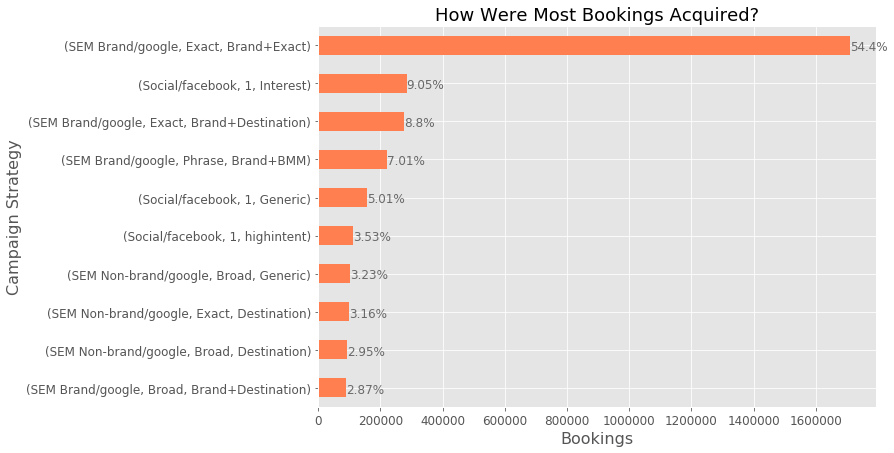

In [19]:
cc = pd.concat([sembrand_sub,sem_nonbrand_sub,social_subchannel_data], ignore_index=False,sort=True)

cc.loc[:,'remarketing_type'] = np.where(cc['match_type'].notna(), cc.loc[:,'match_type'], cc.loc[:,'is_remarketing'])

cc = cc.sort_values(by='bookings', ascending=False)
cc = cc[['remarketing_type','campaign_strategy' ,'cost_per_acq', 'roas','bookings']]

cc = cc.reset_index()
cc = cc.set_index(['index','remarketing_type','campaign_strategy'])
ax = cc['bookings'].head(10).plot(kind='barh', figsize=(10,7),color='coral', fontsize=12);

#ax.set_alpha(0.8)
ax.set_title("How Were Most Bookings Acquired?", fontsize=18)
ax.set_ylabel('Campaign Strategy', fontsize=16)
ax.set_xlabel("Bookings", fontsize=16);
#ax.set_xticks([0, 5, 10, 15, 20])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=12,
color='dimgrey')

# invert for largest on top 
ax.invert_yaxis()

In [20]:
social = df[(df['platform'] =='facebook') & (df['channel'] == 'Social')]
#
social_no_dupes = social[social.duplicated(['calendar_date','tracking_key','platform','channel','campaign_strategy','is_remarketing','bookings', 'revenue'],keep=False) == False]
social_no_dupes = social_no_dupes.groupby(['calendar_date','tracking_key','platform','channel','campaign_strategy','is_remarketing'],as_index=False).agg({'cost':sum, 'bookings':sum,'revenue':sum})
#
social_dupes = social[social.duplicated(['calendar_date','tracking_key','platform','channel','campaign_strategy','is_remarketing','bookings', 'revenue'],keep=False) == True]
social_dupes = social_dupes.groupby(['calendar_date','tracking_key', 'platform','channel','campaign_strategy','is_remarketing'],as_index=False).agg({'cost':sum, 'bookings':'median','revenue':'min'})
#
social_fb = pd.concat([social_no_dupes,social_dupes], ignore_index=True)
#
social_subchannel_data = social.groupby(['channel','platform','is_remarketing', 'campaign_strategy'],as_index=False).agg(sum).sort_values(by='bookings', ascending=False).dropna(axis=0,how='any')
social_subchannel_data = social_subchannel_data.set_index(['channel','platform'])
social_subchannel_data.index = social_subchannel_data.index.map('/'.join).str.strip('/')
#
##social_sub = subchannel_data.loc['SEM Brand/google']
get_percents(social_subchannel_data)
social_subchannel_data = social_subchannel_data[['campaign_strategy','is_remarketing','cost','% of costs','bookings','% of bookings','revenue']]
cpa(social_subchannel_data)
social_subchannel_data

,campaign_strategy,is_remarketing,cost,% of costs,bookings,% of bookings,revenue,cost_per_acq,roas
Social/facebook,Interest,1,7313758.10,0.336398,284247.0,0.501700,16872120.72,25.730291,1.306902
Social/facebook,Generic,1,3459356.28,0.159114,157374.0,0.277767,9176864.97,21.981752,1.652767
Social/facebook,highintent,1,3311877.66,0.152331,110802.0,0.195567,7005854.31,29.890053,1.115372
Social/facebook,Interest,0,3631681.29,0.167040,9549.0,0.016854,425579.70,380.320587,-0.882815
Social/facebook,P1,0,704097.03,0.032385,1611.0,0.002843,75842.13,437.055885,-0.892285
Social/facebook,lowintent,1,700835.92,0.032235,918.0,0.001620,49590.45,763.437821,-0.929241
Social/facebook,highintent,0,366776.87,0.016870,780.0,0.001377,36175.23,470.226756,-0.901370
Social/facebook,In Market,0,228943.76,0.010530,618.0,0.001091,25266.15,370.459159,-0.889640
Social/facebook,lowintent,0,321654.12,0.014795,528.0,0.000932,26516.49,609.193409,-0.917562
Social/facebook,Generic,0,1702389.72,0.078302,141.0,0.000249,6120.66,12073.685957,-0.996405
